# [SWCON253] Machine Learning
Teaching Assistant: Yeongwoong Kim (duddnd7575@khu.ac.kr)

Professor: Hui Yong Kim (hykim.v@khu.ac.kr)

---

# P3:  Deep Learning Framwork: Pytorch를 이용하여 MLP 구현 (10점)

### 학습목표
- pytorch를 사용하여 구현된 MLP 구조를 이해하고 수정할수 있다.
- Fashinon-MNIST 문제를 스스로 해결하면서 딥러닝 학습과정을 이해하고 하이퍼파라미터를 튜닝을 할 수 있다.

### 실습내용
pytorch를 사용하여 구현 되어 있는 MLP를 통해 Fashion-MNIST 데이터셋을 분류하는 classfier를 학습합니다.

실습은 다음 순서로 진행됩니다.
- 1) Fashon-MNIST 데이터셋 설명
- 2) Data loading
- 3) Multilayer Perceptron Model
- 4) Training
- 5) Evaluation
- 6) Discussion

아래 코드에는 2개의 퍼셉트론은 이용한 MLP 모델이 정의 되어 있습니다.
실습을 시작하기전에 이 노트북 파일을 읽고 모든 셀을 실행해하여 올바르게 작동하는지 확인하세요.<br>
이후에 아키텍쳐를 마음껏 변경하여 최고의 성능이 나오도록 수정해 보세요.

다음은 변경 가능한 부분입니다.
- activation 함수 (logistic sigmoid, tanh, relu, leaky relu, ...)
- learning rate
- hidden layers 갯수
- epochs
- minibatch size

그러나 다음 사항은 변경하지 마세요.
- 가중치 초기화 방법
- 랜덤시드
- 최적화 방법, 학습 방법

layer를 추가하여 2개 이상의 hidden layer를 구성할 수 있게 구현하세요. <br>

수정가능한 셀은 아래 주석으로 확실하게 하이라이트되어 표시되어 있습니다.

```
############################################################
# 변경 가능한 셀
############################################################
```

### 점수
**Test set 기준**

- 정확도 85% 이상 2점
- 정확도 86% 이상 4점
- 정확도 87% 이상 6점
- 정확도 88% 이상 8점

**구현**
- Layer 수 2개 이상으로 구현: 2점

`.ipynb 파일과 함께 .html 파일 (File -> export as -> HTML)도 함께 제출하세요. 하나만 제출할시 감점이 있습니다.`

In [6]:
import torch
import os
import numpy as np
import time
import random
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
# Document: https://pytorch.org/docs/stable/nn.functional.html
import matplotlib.pyplot as plt
# Document: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.html
%matplotlib inline

In [7]:
# 이 부분은 절대 변경하지 마세요.

RANDOM_SEED = 123
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## 1) Dataset 설명

이 데이터셋은 기존의 MNIST와 비슷하게 10개의 클래스로 이루어진 데이터셋입니다. 또한 흑백의 28x28크기, 60k개의 학습용 이미지와 10k개의 테스트용 이미지로 구성 되어 있는것과 같이 MNIST와 대부분 비슷한 구조로 이뤄져 있습니다. 

아래는 데이터셋의 샘플 이미지 입니다.

![](https://github.com/zalandoresearch/fashion-mnist/raw/master/doc/img/fashion-mnist-sprite.png)

출처: https://github.com/zalandoresearch/fashion-mnist)



데이터셋의 10개의 클래스는 다음과 같습니다.


| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

## 2) Dataset Loader

In [8]:
import torch
from PIL import Image
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torch.utils.data import DataLoader

import os

In [9]:
# Train 데이터 로딩시 이미지 데이터 전처리를 Transforms를 통해 할 수 있습니다.
# ToTensor는 PIL 형태의 이미지나 ndarray 를 PyTorch 가 이해할 수 있는 tensor 자료형으로 바꾸어 주는 역할을 하며
# Random Flip, Random Crop 등을 사용하여 Data augmentation을 수행하고 이를 통해 좋은 성능을 얻을 수 있습니다.
# 하지만, 이번 실습에서는 사용하지 않습니다.
# Document: https://pytorch.org/vision/stable/transforms.html
custom_train_transform = transforms.Compose([  
                                             transforms.ToTensor(),
                                             transforms.Normalize(mean=(0.5,), std=(0.5,))
])

In [10]:
# Test 데이터 로딩시 데이터 Transform
# Testset의 Trainsform은 Training set 과 다르게 랜덤하게 변경되면 안됩니다.
# 이번 실습에서는 사용하지 않습니다.
custom_test_transform = transforms.Compose([
                                             transforms.ToTensor(),
                                             transforms.Normalize(mean=(0.5,), std=(0.5,))
])

In [211]:
############################################################
# 변경 가능한 셀
############################################################

BATCH_SIZE = 20 # 60000을 사용하면 Full-Batch 학습

In [212]:
train_dataset = FashionMNIST(".", train=True, download=True, transform=custom_train_transform)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          drop_last=True,
                          num_workers=2)


test_dataset = FashionMNIST(".", train=False, download=True, transform=custom_test_transform)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=2)

아래 셀은 데이터셋이 잘 Load 되었는지 확인하는 테스트용 코드입니다.

In [213]:
num_epochs = 2
for epoch in range(num_epochs):

    for batch_idx, (x, y) in enumerate(train_loader):
        
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])
        
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        
        print('break minibatch for-loop')
        break

Epoch: 1 | Batch index: 0 | Batch size: 20
break minibatch for-loop
Epoch: 2 | Batch index: 0 | Batch size: 20
break minibatch for-loop


## 3) Multilayer Perceptron Model

아래 셀은 MLP모델을 정의하는 부분입니다. 이 과제에서 메인 부분입니다.<br>
Hidden layer이 2개가 되도록 변경하세요. 필요에 따라 3개 이상으로 늘려도 됩니다.

In [218]:
############################################################
# 변경 가능한 셀
############################################################

class MLP(torch.nn.Module):

    def __init__(self, num_features, num_hidden_1, num_hidden_2, num_classes):
        super(MLP, self).__init__()
        
        self.num_classes = num_classes
        
        ### 레이어 수 추가
        # 입력층과 1을 연결
        self.linear_1 = torch.nn.Linear(num_features, num_hidden_1) #input size가 num_features이고 output size가 num_hidden_1이다
        
        # <your code> to add layer
        # 1과 2를 연결하는 linear
        self.linear_2 = torch.nn.Linear(num_hidden_1,num_hidden_2)
        
#         # 1과 3을 연결하는 linear
#         self.linear_1_3 = torch.nn.Linear(num_hidden_1,num_hidden_3)
        
#         # 3과 2를 연결하는 linear
#         self.linear_3_2 = torch.nn.Linear(num_hidden_3,num_hidden_2)

        # 2와 class를 연결하는 linear
        self.linear_out = torch.nn.Linear(num_hidden_2, num_classes)
        self.softmax = torch.nn.Softmax(dim=-1)
        
    def forward(self, x):
        
        ### activation 함수 변경 가능
        ### 레이어간의 연결 추가, 변경
        out = self.linear_1(x) 
        out = torch.tanh(out) 
        
        # <your code> to set the layer and the activation function
        
#         # 1 to 3
#         out_1 = self.linear_1_3(out)
#         out_1 = torch.relu(out_1)
        
#         # 3 to 2
#         out_2 = self.linear_3_2(out_1)
#         out = torch.relu(out_2)

        # 1 to 2
        out = self.linear_2(out)
        out = torch.tanh(out)

        logits = self.linear_out(out)
        probas = self.softmax(logits)
        return logits, probas

    
#################################
### Model 초기화
#################################

# random seed는 무작위 가중치 초기화가 항상 같도록 해줍니다.
# 초기화된 가중치에 따라 같은 네트워크도 서로 다른 성능을 낼 수 있어서 
# 실제 사용시에는 좋은 성능을 얻기 위해 여러가지 무작위 가중치를 시도해 볼 수 있습니다.
# 그러나 이 과제에서는 변경하지 않습니다.
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

### num_hidden_1, num_hidden_2 변경 가능, 
### 레이어를 더 추가하고 싶다면 이부분을 알맞게 수정하세요.
model = MLP(num_features=28*28,
            num_hidden_1=512,
            num_hidden_2=256,
            num_classes=10)

model = model.to(DEVICE)

## 4) Training

In [219]:
############################################################
# 변경 가능한 셀
############################################################

### Optimizer는 가중치를 업데이트하는 방법을 바꾸어 더 빠르게 좋은 성능을 낼 수 있도록합니다.
### 이 과제에서는 optimizer를 변경하지 않습니다. 
### 그러나 Learning Rate(lr)는 변경이 가능합니다.
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
############################################################

In [222]:
############################################################
# 변경 가능한 셀
############################################################

NUM_EPOCHS = 10 # 변경 가능
############################################################

In [223]:
def compute_accuracy_and_loss(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    cross_entropy = 0.
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.view(-1, 28*28).to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        cross_entropy += F.cross_entropy(logits, targets).item()
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.cpu().float()/num_examples * 100, cross_entropy/num_examples
    

start_time = time.time()
train_acc_lst, test_acc_lst = [], []
train_loss_lst, test_loss_lst = [], []

for epoch in range(NUM_EPOCHS):
    
    model.train()
    
    for batch_idx, (features, targets) in enumerate(train_loader):
    
        ### PREPARE MINIBATCH
        features = features.view(-1, 28*28).to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        
        # F.cross_entropy calculates the 'softmax' values of a model's output automatically
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 40:
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} |' 
                   f' Cost: {cost:.4f}')

    # no need to build the computation graph for backprop when computing accuracy
    model.eval()
    with torch.set_grad_enabled(False):
        train_acc, train_loss = compute_accuracy_and_loss(model, train_loader, device=DEVICE)
        test_acc, test_loss = compute_accuracy_and_loss(model, test_loader, device=DEVICE)
        train_acc_lst.append(train_acc)
        test_acc_lst.append(test_acc)
        train_loss_lst.append(train_loss)
        test_loss_lst.append(test_loss)
        print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} Train Acc.: {train_acc:.2f}%'
              f' | Test Acc.: {test_acc:.2f}%')
        
    elapsed = (time.time() - start_time)/60
    print(f'Time elapsed: {elapsed:.2f} min')
  
elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')

Epoch: 001/010 | Batch 000/3000 | Cost: 0.6841
Epoch: 001/010 | Batch 040/3000 | Cost: 0.1691
Epoch: 001/010 | Batch 080/3000 | Cost: 0.3158
Epoch: 001/010 | Batch 120/3000 | Cost: 0.3733
Epoch: 001/010 | Batch 160/3000 | Cost: 0.3603
Epoch: 001/010 | Batch 200/3000 | Cost: 0.3353
Epoch: 001/010 | Batch 240/3000 | Cost: 0.2124
Epoch: 001/010 | Batch 280/3000 | Cost: 0.3293
Epoch: 001/010 | Batch 320/3000 | Cost: 0.2517
Epoch: 001/010 | Batch 360/3000 | Cost: 0.4082
Epoch: 001/010 | Batch 400/3000 | Cost: 0.6261
Epoch: 001/010 | Batch 440/3000 | Cost: 0.2658
Epoch: 001/010 | Batch 480/3000 | Cost: 0.5765
Epoch: 001/010 | Batch 520/3000 | Cost: 0.5141
Epoch: 001/010 | Batch 560/3000 | Cost: 0.7724
Epoch: 001/010 | Batch 600/3000 | Cost: 0.6085
Epoch: 001/010 | Batch 640/3000 | Cost: 0.2588
Epoch: 001/010 | Batch 680/3000 | Cost: 0.2514
Epoch: 001/010 | Batch 720/3000 | Cost: 0.4588
Epoch: 001/010 | Batch 760/3000 | Cost: 0.3659
Epoch: 001/010 | Batch 800/3000 | Cost: 0.1410
Epoch: 001/01

Epoch: 003/010 | Batch 760/3000 | Cost: 1.0213
Epoch: 003/010 | Batch 800/3000 | Cost: 0.2751
Epoch: 003/010 | Batch 840/3000 | Cost: 0.2565
Epoch: 003/010 | Batch 880/3000 | Cost: 0.2170
Epoch: 003/010 | Batch 920/3000 | Cost: 0.3022
Epoch: 003/010 | Batch 960/3000 | Cost: 0.1507
Epoch: 003/010 | Batch 1000/3000 | Cost: 0.3692
Epoch: 003/010 | Batch 1040/3000 | Cost: 0.1850
Epoch: 003/010 | Batch 1080/3000 | Cost: 0.2613
Epoch: 003/010 | Batch 1120/3000 | Cost: 0.1933
Epoch: 003/010 | Batch 1160/3000 | Cost: 0.2176
Epoch: 003/010 | Batch 1200/3000 | Cost: 0.6484
Epoch: 003/010 | Batch 1240/3000 | Cost: 0.2970
Epoch: 003/010 | Batch 1280/3000 | Cost: 0.1119
Epoch: 003/010 | Batch 1320/3000 | Cost: 0.5533
Epoch: 003/010 | Batch 1360/3000 | Cost: 0.2658
Epoch: 003/010 | Batch 1400/3000 | Cost: 0.3005
Epoch: 003/010 | Batch 1440/3000 | Cost: 0.3870
Epoch: 003/010 | Batch 1480/3000 | Cost: 0.3991
Epoch: 003/010 | Batch 1520/3000 | Cost: 0.2512
Epoch: 003/010 | Batch 1560/3000 | Cost: 0.089

Epoch: 005/010 | Batch 1520/3000 | Cost: 0.4583
Epoch: 005/010 | Batch 1560/3000 | Cost: 0.2730
Epoch: 005/010 | Batch 1600/3000 | Cost: 0.2415
Epoch: 005/010 | Batch 1640/3000 | Cost: 0.2608
Epoch: 005/010 | Batch 1680/3000 | Cost: 0.2374
Epoch: 005/010 | Batch 1720/3000 | Cost: 0.1172
Epoch: 005/010 | Batch 1760/3000 | Cost: 0.4135
Epoch: 005/010 | Batch 1800/3000 | Cost: 0.2136
Epoch: 005/010 | Batch 1840/3000 | Cost: 0.5746
Epoch: 005/010 | Batch 1880/3000 | Cost: 0.3930
Epoch: 005/010 | Batch 1920/3000 | Cost: 0.1965
Epoch: 005/010 | Batch 1960/3000 | Cost: 0.2382
Epoch: 005/010 | Batch 2000/3000 | Cost: 0.4218
Epoch: 005/010 | Batch 2040/3000 | Cost: 0.5087
Epoch: 005/010 | Batch 2080/3000 | Cost: 0.5383
Epoch: 005/010 | Batch 2120/3000 | Cost: 0.3488
Epoch: 005/010 | Batch 2160/3000 | Cost: 0.6232
Epoch: 005/010 | Batch 2200/3000 | Cost: 0.6568
Epoch: 005/010 | Batch 2240/3000 | Cost: 0.6558
Epoch: 005/010 | Batch 2280/3000 | Cost: 0.2532
Epoch: 005/010 | Batch 2320/3000 | Cost:

Epoch: 007/010 | Batch 2280/3000 | Cost: 0.6226
Epoch: 007/010 | Batch 2320/3000 | Cost: 0.1829
Epoch: 007/010 | Batch 2360/3000 | Cost: 0.5524
Epoch: 007/010 | Batch 2400/3000 | Cost: 0.2007
Epoch: 007/010 | Batch 2440/3000 | Cost: 0.2985
Epoch: 007/010 | Batch 2480/3000 | Cost: 0.2799
Epoch: 007/010 | Batch 2520/3000 | Cost: 0.3945
Epoch: 007/010 | Batch 2560/3000 | Cost: 0.3053
Epoch: 007/010 | Batch 2600/3000 | Cost: 0.2024
Epoch: 007/010 | Batch 2640/3000 | Cost: 0.3884
Epoch: 007/010 | Batch 2680/3000 | Cost: 0.2724
Epoch: 007/010 | Batch 2720/3000 | Cost: 0.5627
Epoch: 007/010 | Batch 2760/3000 | Cost: 0.2955
Epoch: 007/010 | Batch 2800/3000 | Cost: 0.7937
Epoch: 007/010 | Batch 2840/3000 | Cost: 0.2980
Epoch: 007/010 | Batch 2880/3000 | Cost: 0.2596
Epoch: 007/010 | Batch 2920/3000 | Cost: 0.2548
Epoch: 007/010 | Batch 2960/3000 | Cost: 0.1680
Epoch: 007/010 Train Acc.: 89.16% | Test Acc.: 86.70%
Time elapsed: 5.14 min
Epoch: 008/010 | Batch 000/3000 | Cost: 0.3158
Epoch: 008/0

Epoch: 010/010 | Batch 000/3000 | Cost: 0.4094
Epoch: 010/010 | Batch 040/3000 | Cost: 0.3754
Epoch: 010/010 | Batch 080/3000 | Cost: 0.1870
Epoch: 010/010 | Batch 120/3000 | Cost: 0.1311
Epoch: 010/010 | Batch 160/3000 | Cost: 0.3448
Epoch: 010/010 | Batch 200/3000 | Cost: 0.5384
Epoch: 010/010 | Batch 240/3000 | Cost: 0.1726
Epoch: 010/010 | Batch 280/3000 | Cost: 0.4974
Epoch: 010/010 | Batch 320/3000 | Cost: 0.4845
Epoch: 010/010 | Batch 360/3000 | Cost: 0.3293
Epoch: 010/010 | Batch 400/3000 | Cost: 0.2491
Epoch: 010/010 | Batch 440/3000 | Cost: 0.2088
Epoch: 010/010 | Batch 480/3000 | Cost: 0.0845
Epoch: 010/010 | Batch 520/3000 | Cost: 0.1217
Epoch: 010/010 | Batch 560/3000 | Cost: 0.2384
Epoch: 010/010 | Batch 600/3000 | Cost: 0.2219
Epoch: 010/010 | Batch 640/3000 | Cost: 0.3785
Epoch: 010/010 | Batch 680/3000 | Cost: 0.0559
Epoch: 010/010 | Batch 720/3000 | Cost: 0.4483
Epoch: 010/010 | Batch 760/3000 | Cost: 0.3157
Epoch: 010/010 | Batch 800/3000 | Cost: 0.0699
Epoch: 010/01

## 5) Evaluation

테스트 데이터와 학습 데이터의 Loss변화를 확인합니다.

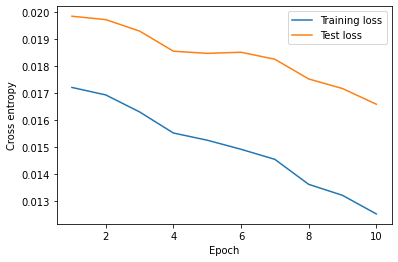

In [226]:
plt.plot(range(1, NUM_EPOCHS+1), train_loss_lst, label='Training loss')
plt.plot(range(1, NUM_EPOCHS+1), test_loss_lst, label='Test loss')
plt.legend(loc='upper right')
plt.ylabel('Cross entropy')
plt.xlabel('Epoch')
plt.show()

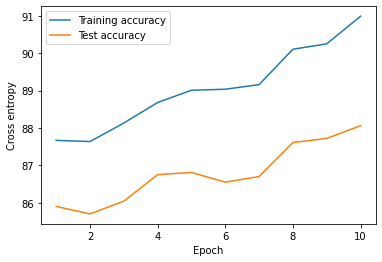

In [227]:
plt.plot(range(1, NUM_EPOCHS+1), train_acc_lst, label='Training accuracy')
plt.plot(range(1, NUM_EPOCHS+1), test_acc_lst, label='Test accuracy')
plt.legend(loc='upper left')
plt.ylabel('Cross entropy')
plt.xlabel('Epoch')
plt.show()

In [228]:
model.eval()
with torch.set_grad_enabled(False): # save memory during inference
    test_acc, test_loss = compute_accuracy_and_loss(model, test_loader, DEVICE)
    print(f'Test accuracy: {test_acc:.2f}%')

Test accuracy: 88.06%


## 6) Discussion

**1) 학습, 테스트 정확도는 얼마인가요? (위 숫자를 복사하세요.)**

- Training:  90.99%
- Test 88.06%

**2) overfitting을 경험했나요? 만약 그랬다면 왜 그랬을지 적어보고, overfitting을 방지하기위한 간단한 방법은 무엇일까요?**

[제안하는 방법 적기]

예를 들면, 

- batch size를 256으로 변경
- 두개의 hidden layers의 activation을 relu로 변경
- learning rate를 0.2로 변경

가끔씩 train_data_set의 정확도는 높은데 test_data_set의 정확도는 낮은 경우가 발생했다. 정확히 왜 발생했는지는 알 수 없었지만 개인적으로 활성화 함수를 바꾸어 주면서 해결을 했던 것 같다. 결국 softmax함수를 했을 때 overfitting이 발생하지 않고 결과가 잘 나왔다.

**3) 만약 hidden layer 수가 늘어나면(3개 이상) 얻을 수 있는 장/단점은 무엇일까요?**

[답변작성]
hidden layer수가 더욱 늘어나면 분류할 수 있는 decision boundary가 많아진다. 이는 data set을 더 세분화하여 분리할 수 있다는 것을 뜻해서 정답률이 높아질 수 도있지만 너무 세밀하게 분류되어 원래의 정답값과 달라져서 오히려 정답률이 떨어질 수도 있다. 

**4) 구현하면서 수정한 부분에 대해 작성하여 수정한 이유 및 성능향상이 생긴 이유에 대해 답해보세요.**

[답변작성] 구현을 하면서 epoch와 hidden layer의 node부분, batch size, 은닉층의 개수를 수정했었다. 처음에는 은닉층의 개수를 3개로 늘렸는데 계속 10%가 나와서 2개로 고정을 시켰다. 그리고 은닉층의 node를 처음에는 10개 20개 정도로 했지만 node를 늘려서 좀 더 분류의 정확도를 높이고 512, 256으로 고정을 시켰다. batch size의 경우 처음 64개가 생각보다 정확도가 높지 않아서 20개까지 줄였고 epoch의 경우에는 10까지 올렸다. 시간은 많이 들었지만 많은 학습이 이루어져서 정확도가 많이 높아졌다.